In [1]:
#Import all necessary libraries and modules
! pip install --upgrade pip
! pip3 install wordcloud
! pip3 install pyhive
! pip3 install thrift

from wordcloud import WordCloud, STOPWORDS
from pyhive import presto, hive

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import re
import json

### Please enter the date you'd like to check in 'YYYY-MM-DDD' format below.

In [2]:
date_to_check='2021-08-06'

In [ ]:
#Establish Presto Connection
conn = presto.connect(
    host='presto',
    port=8080,
    catalog='hive',
    schema='default',
)
playlist_query="select accept from default.playlist WHERE substr(host,1,10) = \'"+date_to_check+"\'"
playlist_day = pd.read_sql_query(playlist_query, conn)

In [3]:
# Using presto connection
from pyhive import presto 
conn = presto.connect(
    host='presto',
    port=8080,
    catalog='hive',
    schema='default',
)
playlist_query="select accept from default.playlist WHERE substr(host,1,10) = \'"+date_to_check+"\'"
playlist_day = pd.read_sql_query(playlist_query, conn)

lyrics_query="select accept from default.lyrics WHERE substr(host,1,10) = \'"+date_to_check+"\'"
lyrics_day = pd.read_sql_query(lyrics_query, conn)

json_playlist=json.loads(playlist_day.iloc[0,0])
playlist_day=json_playlist["playlist_json"]

json_lyrics=json.loads(lyrics_day.iloc[0,0])
lyrics_day=json_lyrics["lyrics_json"]

full_top_table=pd.concat([pd.DataFrame(playlist_day),pd.DataFrame(lyrics_day)]).transpose()

## using bash terminal to .csv instead

!docker-compose exec presto presto --server presto:8080 --catalog hive --schema default --execute \ "{playlist_query}" --output-format CSV_HEADER > playlist_day.csv

!docker-compose exec presto presto --server presto:8080 --catalog hive --schema default --execute \ "{lyrics_query}" --output-format CSV_HEADER > lyrics_day.csv

pd_playlist=pd.read_csv('playlist_day.csv') json_playlist=json.loads(pd_playlist.iloc[0,0]) playlist_day=json_playlist["playlist_json"]

pd_lyrics=pd.read_csv('lyrics_day.csv') json_lyrics=json.loads(pd_lyrics.iloc[0,0]) lyrics_day=json_lyrics["lyrics_json"]

full_top_table=pd.concat([pd.DataFrame(playlist_day),pd.DataFrame(lyrics_day)]).transpose()

### Top 50 List

In [9]:
#Show top 50 list
full_top_table[["song","artist"]]

,song,artist
1,STAY (with Justin Bieber),"The Kid LAROI, Justin Bieber"
2,INDUSTRY BABY (feat. Jack Harlow),"Lil Nas X, Jack Harlow"
3,Happier Than Ever,Billie Eilish
4,good 4 u,Olivia Rodrigo
5,Bad Habits,Ed Sheeran
6,Beggin',Måneskin
7,Kiss Me More (feat. SZA),"Doja Cat, SZA"
8,Save Your Tears (with Ariana Grande) (Remix),"The Weeknd, Ariana Grande"
9,Levitating (feat. DaBaby),"Dua Lipa, DaBaby"
10,MONTERO (Call Me By Your Name),Lil Nas X


### What track number would you like to analyze?

In [25]:
track_choice = 29

In [26]:
#Runs Analysis
#Finds song
lyrics = full_top_table.iloc[track_choice - 1, 5]

#cuts song to fit Tisane's character requirement
lyrics = lyrics[0:2000]

#Build dictionary to send to Tisane
tisane_dict = {}
tisane_dict["language"] = "en"
tisane_dict["content"] = (str(lyrics))
tisane_dict["settings"] = {}
jsonString = json.dumps(tisane_dict)

#Send dictionary to Tisane
url = 'https://api.tisane.ai/parse'
headers = {'Ocp-Apim-Subscription-Key': '6d2c4504bd164125bab7e7375206dd31', 'Content-Type': 'application/json'}
r = requests.post(url, data=jsonString, headers=headers)

#Unpack Tisane output
tisane_output_string = r.text
y = json.loads(tisane_output_string)

data = {'song_name': 'Test', 'lyrics': '', 'sentiment_expressions':0, 'abuse':{'profanity_severity':0, 'adult_only':0, 'sexual_advances':0,
                                                          'bigotry':0}}
#Build Kid score
for category in y:
    if category == 'abuse':
        for item in y['abuse']:
            if item['type'] == 'profanity':
                if item['severity'] == 'low':
                    data['abuse']['profanity_severity'] += 1
                elif item['severity'] == 'medium':
                    data['abuse']['profanity_severity'] += 2
                elif item['severity'] == 'high':
                    data['abuse']['profanity_severity'] += 3
                elif item['severity'] == 'extreme':
                    data['abuse']['profanity_severity'] += 4
            if item['type'] == 'adult_only':
                if item['severity'] == 'low':
                    data['abuse']['adult_only'] += 1
                elif item['severity'] == 'medium':
                    data['abuse']['adult_only'] += 2
                elif item['severity'] == 'high':
                    data['abuse']['adult_only'] += 3
                elif item['severity'] == 'extreme':
                    data['abuse']['adult_only'] += 4
            elif item['type'] == 'sexual_advances':
                if item['severity'] == 'low':
                    data['abuse']['sexual_advances'] += 1
                elif item['severity'] == 'medium':
                    data['abuse']['sexual_advances'] += 2
                elif item['severity'] == 'high':
                    data['abuse']['sexual_advances'] += 3
                elif item['severity'] == 'extreme':
                    data['abuse']['sexual_advances'] += 4
            elif item['type'] == 'bigotry':
                if item['severity'] == 'low':
                    data['abuse']['bigotry'] += 1
                elif item['severity'] == 'medium':
                    data['abuse']['bigotry'] += 2
                elif item['severity'] == 'high':
                    data['abuse']['bigotry'] += 3
                elif item['severity'] == 'extreme':
                    data['abuse']['bigotry'] += 4
            else:
                pass
    if category == 'text':
        for lyric in y['text']:
            data['lyrics'] += lyric
    if category == 'sentiment_expressions':
        for sentiment in y['sentiment_expressions']:
            if sentiment['polarity'] == 'negative':
                data['sentiment_expressions'] += -1
            elif sentiment['polarity'] == 'positive':
                data['sentiment_expressions'] += 1
            elif sentiment['polarity'] == 'mixed':
                data['sentiment_expressions'] += 0
            else:
                pass
    
else:
    pass
    

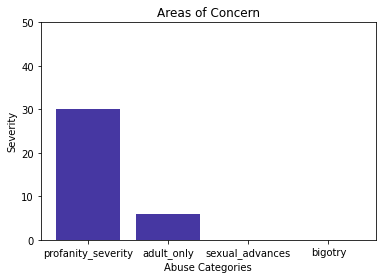

In [27]:
#Kid Scores by category
keys = data['abuse'].keys()
values = data['abuse'].values()

plt.bar(keys, values, color='#4637a2')
plt.ylim(0,50)
plt.xlabel('Abuse Categories')
plt.ylabel('Severity')
plt.title('Areas of Concern')
plt.show()

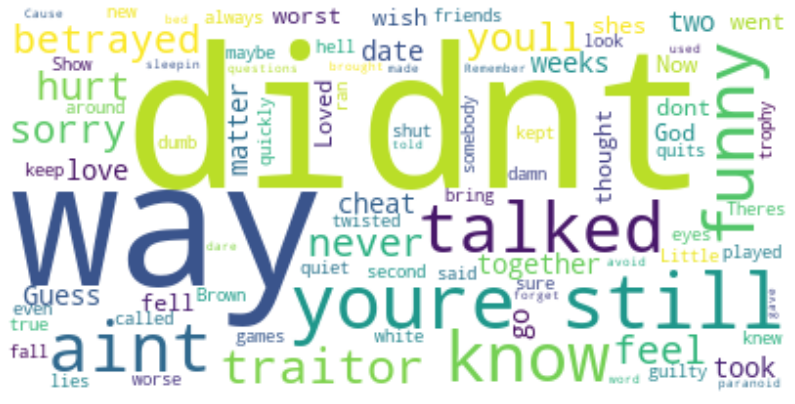

In [24]:
#Build Word Cloud
stop_words = ['got','let', 'ah', 'yeah', 'oh', 'ooh', 'im'] + list(STOPWORDS)

songs_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stop_words
)

# generate the word cloud
songs_wc.generate(data['lyrics'])

# display the word cloud
plt.figure(figsize=(14, 18))
plt.imshow(songs_wc, interpolation='bilinear')
plt.axis('off')
plt.show()